# Scaling Elastic Wave Equations from Virieux 1986

In [1]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Implementing unscaled constant parameter propagation

In [2]:
# Set up the grid
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# Create the velocity and stress fields
# space order 4 works best
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=4, time_order=1)
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=4, time_order=1)

# Define constants
constants = {
    "vp": 3,
    "vs": 1.5,
    "density": 2.4,
    "f0": 0.03
}

# Find dt using CFL condition
vmax = max(constants['vp'], constants['vs'])
dt = np.amin(grid.spacing) * 0.6 / vmax

# Define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Create the source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)

# Setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# Source term injections
src_xx = src.inject(field=tau[0, 0].forward, expr=src)
src_zz = src.inject(field=tau[1, 1].forward, expr=src)
src_xz = src.inject(field=tau[0, 1].forward, expr=src)

# define equations
eq_v = v.dt - 1/constants["density"]*dv.div(tau)
eq_tau = tau.dt - constants["density"] * (constants["vp"]**2 - 2 * constants["vs"]**2) * dv.diag(dv.div(v.forward)) - constants["density"] * constants["vs"]**2 * (dv.grad(v.forward) + dv.grad(v.forward).transpose(inner=False))

# Define stencils
stencil_v = dv.Eq(v.forward, dv.solve(eq_v, v.forward))
stencil_tau = dv.Eq(tau.forward, dv.solve(eq_tau, tau.forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_v, stencil_tau] + src_xx + src_zz)
op(dt=dt)


Operator `Kernel` ran in 0.04 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.03708299999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

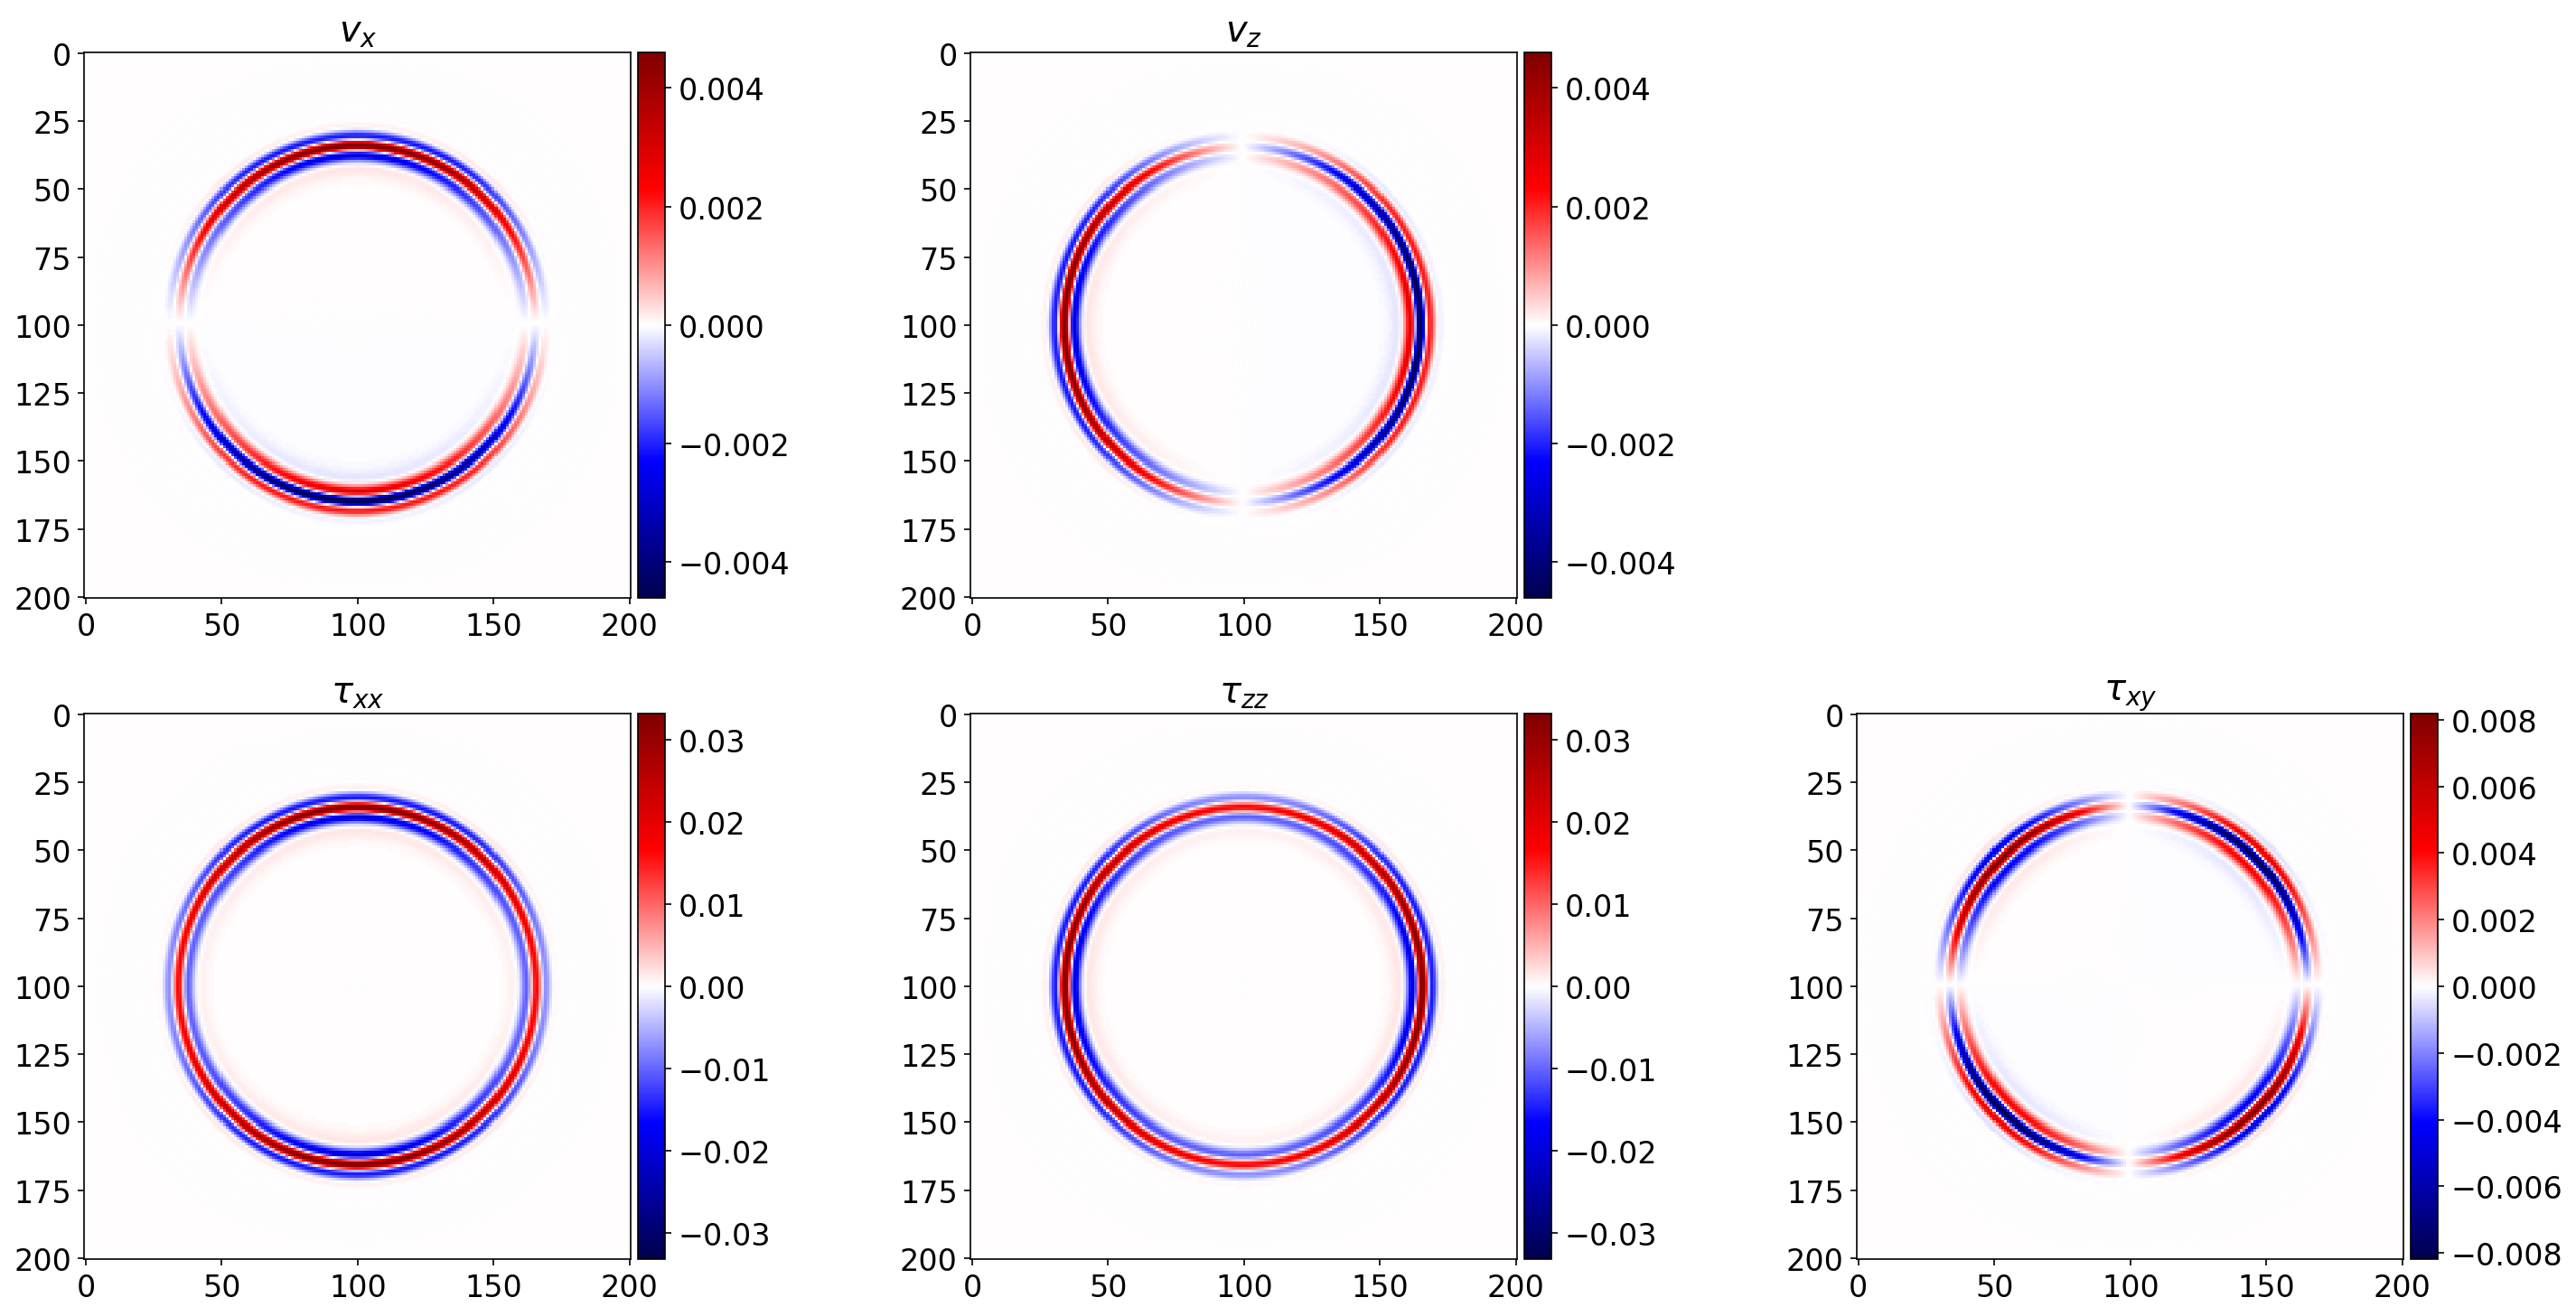

In [3]:
# Data fields to display: v_x, v_z, tau_xx, tau_zz, tau_xz
fields = {
    "v_x": v[0].data[0],  # v_x field
    "v_z": v[1].data[0],  # v_z field
    "tau_xx": tau[0, 0].data[0],  # tau_xx field
    "tau_zz": tau[1, 1].data[0],  # tau_zz field
    "tau_xz": tau[0, 1].data[0]   # tau_xz field
}

titles = {
    "v_x": r"$v_{x}$",
    "v_z": r"$v_{z}$",
    "tau_xx": r"$\tau_{xx}$",
    "tau_zz": r"$\tau_{zz}$",
    "tau_xz": r"$\tau_{xy}$"
}

# Create the figure and subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=150)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Assign the fields to specific subplots
top_row_indices = [0, 1]  # Top row: 2 plots
bottom_row_indices = [3, 4, 5]  # Bottom row: 3 plots

# List of fields in desired order (top: velocities, bottom: stresses)
plot_fields = ['v_x', 'v_z', 'tau_xx', 'tau_zz', 'tau_xz']

# Plot the velocity fields on the top row
for i, field in enumerate(plot_fields[:2]):
    ax = axes[top_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields[field]
    vmax = np.amax(np.abs(data))

    # Plot the field using imshow
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles[field])

# Plot the stress fields on the bottom row
for i, field in enumerate(plot_fields[2:]):
    ax = axes[bottom_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields[field]
    vmax = np.amax(np.abs(data))

    # Plot the field using imshow
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles[field])

# Remove the empty subplot (top-right)
fig.delaxes(axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the complete figure with all subplots
plt.show()


### Creating a variable parameter model

<div style="text-align: center;">
    <img src="Figures\elastic-variable-model.png" alt="Velocity Model" style="width:1000px; margin: 20px;"/>
</div>

In [4]:
# Create spatial fields for Vp, Vs, and density
Vp = dv.Function(name="Vp", grid=grid)
Vs = dv.Function(name="Vs", grid=grid)
rho = dv.Function(name="rho", grid=grid)

# Define layer interfaces (in grid points)
layer1_depth = int(shape[0] / 4)  # 1st layer: top 1/4th of the model
layer2_depth = int(shape[0] / 2)  # 2nd layer: next 1/4th
layer3_depth = int(3 * shape[0] / 4)  # 3rd layer: next 1/4th
layer4_depth = shape[0]  # 4th layer: bottom 1/4th

# Assign values for each layer
# Layer 1 (water-like)
Vp.data[:layer1_depth, :] = 1500  # m/s
Vs.data[:layer1_depth, :] = 0  # m/s (water-like)
rho.data[:layer1_depth, :] = 1000  # kg/m^3

# Layer 2
Vp.data[layer1_depth:layer2_depth, :] = 2000  # m/s
Vs.data[layer1_depth:layer2_depth, :] = 800  # m/s
rho.data[layer1_depth:layer2_depth, :] = 2000  # kg/m^3

# Layer 3
Vp.data[layer2_depth:layer3_depth, :] = 3000  # m/s
Vs.data[layer2_depth:layer3_depth, :] = 1500  # m/s
rho.data[layer2_depth:layer3_depth, :] = 2500  # kg/m^3

# Layer 4
Vp.data[layer3_depth:layer4_depth, :] = 4000  # m/s
Vs.data[layer3_depth:layer4_depth, :] = 2000  # m/s
rho.data[layer3_depth:layer4_depth, :] = 3000  # kg/m^3


### Implementing unscaled variable parameter propagation

In [5]:
# create new functions to store velocity and stress
v_v = dv.VectorTimeFunction(name='v_v', grid=grid, space_order=4, time_order=1)
tau_v = dv.TensorTimeFunction(name='tau_v', grid=grid, space_order=4, time_order=1)

# define dictionary for physical parameters in SI units
parameters = {
    'vp': Vp,
    'vs': Vs,
    'density': rho,
    'f0': 30,
    'tn': 0.25
}

# calculate the maximum velocity to find timestep - the Vp field will contain this
vmax = float(np.max(Vp.data))
dt = float(np.amin(grid.spacing) * 0.6 / vmax)

# define a time range for the source term
t0 = 0
tn = parameters['tn']
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term
src = RickerSource(name='src', grid=grid, f0=parameters["f0"], npoint=1, time_range=time_range)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# Source term injections
src_xx = src.inject(field=tau_v[0, 0].forward, expr=src)
src_zz = src.inject(field=tau_v[1, 1].forward, expr=src)
src_xz = src.inject(field=tau_v[0, 1].forward, expr=src)

# define equations with new velocities
eq_v_v = v_v.dt - 1/parameters["density"]*dv.div(tau_v)
eq_tau_v = tau_v.dt - parameters["density"] * (parameters["vp"]**2 - 2 * parameters["vs"]**2) * dv.diag(dv.div(v_v.forward)) - parameters["density"] * parameters["vs"]**2 * (dv.grad(v_v.forward) + dv.grad(v_v.forward).transpose(inner=False))

# Define stencils
stencil_v_v = dv.Eq(v_v.forward, dv.solve(eq_v_v, v_v.forward))
stencil_tau_v = dv.Eq(tau_v.forward, dv.solve(eq_tau_v, tau_v.forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_v_v, stencil_tau_v] + src_xx + src_zz)
op(dt=dt)


Operator `Kernel` ran in 0.06 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.056049999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=8e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

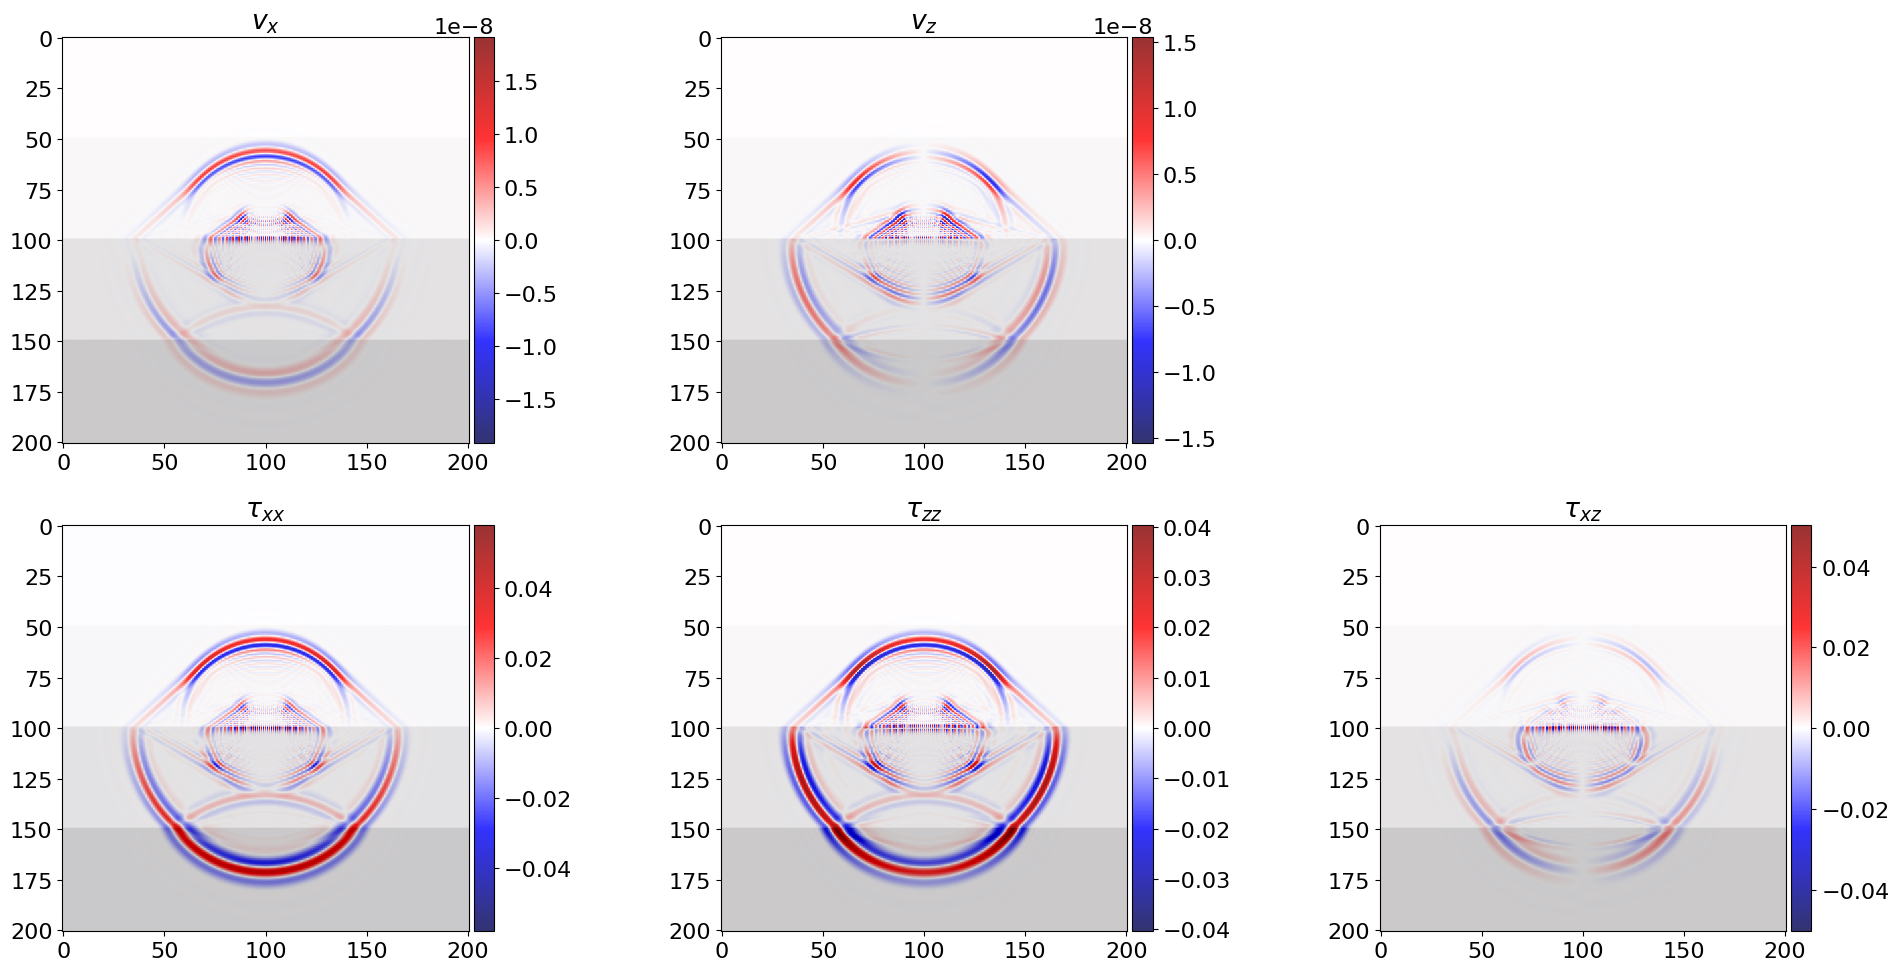

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Data fields to display: v_v_x, v_v_z, tau_v_xx, tau_v_zz, tau_v_xz
fields_vv = {
    "v_v_x": v_v[0].data[0],  # v_v_x field
    "v_v_z": v_v[1].data[0],  # v_v_z field
    "tau_v_xx": tau_v[0, 0].data[0],  # tau_v_xx field
    "tau_v_zz": tau_v[1, 1].data[0],  # tau_v_zz field
    "tau_v_xz": tau_v[0, 1].data[0]   # tau_v_xz field
}

# Titles for the respective fields
titles_vv = {
    "v_v_x": r"$v_{x}$",
    "v_v_z": r"$v_{z}$",
    "tau_v_xx": r"$\tau_{xx}$",
    "tau_v_zz": r"$\tau_{zz}$",
    "tau_v_xz": r"$\tau_{xz}$"
}

# Background velocity model (vp), assumed to be provided from earlier in your workflow
# vp.data will be overlaid as the background
vp_data = Vp.data

# Create the figure and subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Assign the fields to specific subplots
top_row_indices = [0, 1]  # Top row: 2 plots for velocities
bottom_row_indices = [3, 4, 5]  # Bottom row: 3 plots for stresses

# List of fields in desired order (top: velocities, bottom: stresses)
plot_fields_vv = ['v_v_x', 'v_v_z', 'tau_v_xx', 'tau_v_zz', 'tau_v_xz']

# Plot the velocity fields on the top row
for i, field in enumerate(plot_fields_vv[:2]):
    ax = axes[top_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields_vv[field]
    vmax = np.amax(np.abs(data))

    # First, plot the velocity model (vp) as the background
    ax.imshow(vp_data, cmap='Greys', interpolation='hanning')

    # Overlay the wave propagation field with transparency
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles_vv[field])

# Plot the stress fields on the bottom row
for i, field in enumerate(plot_fields_vv[2:]):
    ax = axes[bottom_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields_vv[field]
    vmax = np.amax(np.abs(data))

    # First, plot the velocity model (vp) as the background
    ax.imshow(vp_data, cmap='Greys', interpolation='hanning')

    # Overlay the wave propagation field with transparency
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax, alpha=0.8)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles_vv[field])

# Remove the empty subplot (top-right)
fig.delaxes(axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the complete figure with all subplots
plt.show()
